# Example: Optimal control of a PWA System by State-feedback Abstractions solved by [Ellipsoid abstraction](https://github.com/dionysos-dev/Dionysos.jl/blob/master/docs/src/manual/manual.md#solvers).


This document reproduces [1, Example 2], which is a possible application of state-feedback transition system for the optimal control of piecewise-affine systems.
Consider a system $\mathcal{S}:=(\mathcal{X}, \mathcal{U},\rightarrow_F)$ with the transition function
$$
\begin{equation}
    \{A_{\psi(x)}x+B_{\psi(x)}u+g_{\psi(x)}\}\oplus\Omega_{\psi(x)}
\end{equation}
$$
where $\psi:\mathcal{X}\rightarrow\{1,\dots,N_p\}$ selects one of the $N_p$ subsystems defined by the matrices
$$
\begin{equation}
	A_1=\begin{bmatrix}
    1.01 & 0.3\\
    -0.1 & 1.01
\end{bmatrix}, ~B_1=\begin{bmatrix}
    1&0\\ 0 & 1
\end{bmatrix},~g_1=\begin{bmatrix}
-0.1\\-0.1
\end{bmatrix},
\end{equation}
$$
$A_2=A_1^\top,~ A_3=A_1,~B_2=B_3=B_1,~g_2=0$ and $g_3=-g_1$. These systems are three spiral sources with unstable equilibria at $x_{e1}=[-0.9635~~0.3654]^\top,~x_{e2}=0,$ and $x_{e3}=-x_{e1}$. We also define the additive-noise sets $\Omega_1=\Omega_2=\Omega_3=[-0.05,0.05]^2$, the control-input set $\mathcal{U}=[-0.5,0.5]^2$ and the state space $\mathcal{X}=[-2,2]^2$. The $N_p=3$ partitions of $\mathcal{X}$ are $\mathcal{X}_1= \{x\in\mathcal{X}~:~x_1\leq-1 \},~\mathcal{X}_3= \{x\in\mathcal{X}~:~x_1>1 \},$ and $\mathcal{X}_2=\mathcal{X}\setminus(\mathcal{X}_1\cup\mathcal{X}_3)$. The goal is to bring the state $x$ from the initial set $\mathcal{X}_0$ to a final set $\mathcal{X}_*$, while avoiding the obstacle $\mathcal{O}$, which are to be defined.

First, let us import
[StaticArrays](https://github.com/JuliaArrays/StaticArrays.jl),
[LinearAlgebra](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/),
[CDDLib](https://github.com/JuliaPolyhedra/CDDLib.jl),
[Clarabel](https://github.com/oxfordcontrol/Clarabel.jl),
[JuMP](https://jump.dev/JuMP.jl/stable/). We also instantiate our optimizers and CDDLib.

In [1]:
using StaticArrays, LinearAlgebra, Plots
using JuMP, Clarabel
import CDDLib

import Random
Random.seed!(0)

using Dionysos
const DI = Dionysos
const UT = DI.Utils
const DO = DI.Domain
const ST = DI.System
const SY = DI.Symbolic
const PR = DI.Problem
const OP = DI.Optim
const AB = OP.Abstraction

lib = CDDLib.Library() # polyhedron lib

include(joinpath(dirname(dirname(pathof(Dionysos))), "problems", "pwa_sys.jl"))

Main.var"##877".PWAsys

# Problem parameters
Notice that in [1] it was used `Wsz = 5` and `Usz = 50`. These, and other values were changed here to speed up the build time of the documentation.

In [2]:
Usz = 70 # upper limit on |u|, `Usz = 50` in [1]
Wsz = 3 # `Wsz = 5` in [1]
dt = 0.01; # discretization step

concrete_problem =
    PWAsys.problem(; lib = lib, dt = dt, Usz = Usz, Wsz = Wsz, simple = false)
concrete_system = concrete_problem.system

Hybrid System with automaton HybridSystems.GraphAutomaton{Graphs.SimpleGraphs.SimpleDiGraph{Int64}, Graphs.SimpleGraphs.SimpleEdge{Int64}}(Graphs.SimpleGraphs.SimpleDiGraph{Int64}(7, [[1, 2], [1, 2, 3], [2, 3]], [[1, 2], [1, 2, 3], [2, 3]]), Dict{Graphs.SimpleGraphs.SimpleEdge{Int64}, Dict{Int64, Int64}}(Edge 3 => 2 => Dict(4 => 2), Edge 1 => 2 => Dict(1 => 2), Edge 1 => 1 => Dict(3 => 1), Edge 3 => 3 => Dict(7 => 3), Edge 2 => 2 => Dict(5 => 2), Edge 2 => 1 => Dict(2 => 1), Edge 2 => 3 => Dict(6 => 3)), 7, 7)

# Abstraction parameters
This is state-space is defined by the `HyperRectangle rectX`. We also define a control space with the same bounds. This is done because, for a state-feedback abstraction, selecting a controller out of the set of controllers is the same as selecting a destination state out of the set of cells $\mathcal{X}_d$, given it's determinism.
To build this deterministic state-feedback abstraction in alternating simulation relation  with the system as described in [1, Lemma 1], a set of balls of radius 0.2 covering the state space is adopted as cells $\xi\in\mathcal{X}_d$. We assume that inside cells intersecting the boundary of partitions of $\mathcal{X}$ the selected piecewise-affine mode is the same all over its interior and given by the mode defined at its center. An alternative to this are discussed in [1]. Let us define the corresponding grid:

In [3]:
n_step = 3
X_origin = SVector(0.0, 0.0);
X_step = SVector(1.0 / n_step, 1.0 / n_step)
nx = size(concrete_system.resetmaps[1].A, 1)
P = (1 / nx) * diagm((X_step ./ 2) .^ (-2))
state_grid = DO.GridEllipsoidalRectangular(X_origin, X_step, P);
opt_sdp = optimizer_with_attributes(Clarabel.Optimizer, MOI.Silent() => true)

optimizer = MOI.instantiate(AB.EllipsoidsAbstraction.Optimizer)
MOI.set(optimizer, MOI.RawOptimizerAttribute("concrete_problem"), concrete_problem)
MOI.set(optimizer, MOI.RawOptimizerAttribute("state_grid"), state_grid)
MOI.set(optimizer, MOI.RawOptimizerAttribute("sdp_solver"), opt_sdp)

MathOptInterface.OptimizerWithAttributes(Clarabel.MOIwrapper.Optimizer, Pair{MathOptInterface.AbstractOptimizerAttribute, Any}[MathOptInterface.Silent() => true])

Build the state-feedback abstraction and solve the optimal control problem by through Dijkstra's algorithm [2, p.86].

In [4]:
MOI.optimize!(optimizer)

compute_symmodel_from_hybridcontrolsystem! started
Computing symbolic control system: 100%|████████████████| Time: 0:00:21
compute_symmodel_from_controlsystem! terminated with success: 1012 transitions created
Abstraction created in 22.226245321 seconds with 1012 transitions
Abstract controller computed with: succes


Get the results

In [5]:
abstract_system = MOI.get(optimizer, MOI.RawOptimizerAttribute("abstract_system"))
abstract_problem = MOI.get(optimizer, MOI.RawOptimizerAttribute("abstract_problem"))
abstract_controller = MOI.get(optimizer, MOI.RawOptimizerAttribute("abstract_controller"))
concrete_controller = MOI.get(optimizer, MOI.RawOptimizerAttribute("concrete_controller"))
abstract_lyap_fun = MOI.get(optimizer, MOI.RawOptimizerAttribute("abstract_lyap_fun"))
concrete_lyap_fun = MOI.get(optimizer, MOI.RawOptimizerAttribute("concrete_lyap_fun"))
transitionCont = MOI.get(optimizer, MOI.RawOptimizerAttribute("transitionCont"))
transitionCost = MOI.get(optimizer, MOI.RawOptimizerAttribute("transitionCost"));

## Define the mapping function

In [6]:
#Return pwa mode for a given x
get_mode(x) = findfirst(m -> (x ∈ m.X), concrete_system.resetmaps)

get_mode (generic function with 1 method)

To simplify : "We assume that inside cells intersecting the boundary of partitions of X the selected piecewise-affine mode is the same all over its interior and given by the mode
defined at its center."

In [7]:
function f_eval1(x, u)
    states = SY.get_states_by_xpos(
        abstract_system,
        DO.crop_to_domain(abstract_system.Xdom, DO.get_all_pos_by_coord(state_grid, x)),
    )
    from = nothing
    for s in states
        if ST.is_defined(abstract_controller, s)
            from = s
            break
        end
    end
    c = DO.get_coord_by_pos(state_grid, SY.get_xpos_by_state(abstract_system, from))
    m = get_mode(c)
    W = concrete_system.ext[:W]
    w = (2 * (rand(2) .^ (1 / 4)) .- 1) .* W[:, 1]
    return concrete_system.resetmaps[m].A * x +
           concrete_system.resetmaps[m].B * u +
           concrete_system.resetmaps[m].c +
           w
end

cost_eval(x, u) = UT.function_value(concrete_problem.transition_cost[1][1], x, u)

cost_eval (generic function with 1 method)

### Simulation

We define the stopping criteria for a simulation

In [8]:
nstep = typeof(concrete_problem.time) == PR.Infinity ? 100 : concrete_problem.time; #max num of steps
function reached(x)
    states = SY.get_states_by_xpos(
        abstract_system,
        DO.crop_to_domain(abstract_system.Xdom, DO.get_all_pos_by_coord(state_grid, x)),
    )
    if !isempty(states ∩ abstract_problem.target_set)
        return true
    else
        return false
    end
end

reached (generic function with 1 method)

We simulate the closed loop trajectory

In [9]:
x0 = concrete_problem.initial_set
cost_control_trajectory = ST.get_closed_loop_trajectory(
    f_eval1,
    concrete_controller,
    cost_eval,
    x0,
    nstep;
    stopping = reached,
)
cost_bound = concrete_lyap_fun(x0)
cost_true = sum(cost_control_trajectory.costs.seq);
println("Goal set reached")
println("Guaranteed cost:\t $(cost_bound)")
println("True cost:\t\t $(cost_true)")

Goal set reached
Guaranteed cost:	 2.4407918199375933
True cost:		 1.756527500234811


### Visualize the results.

In [10]:
rectX = concrete_system.ext[:X];

## Display the specifications and domains

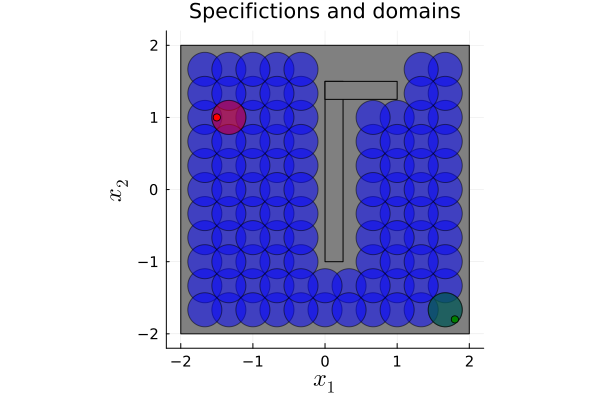

In [11]:
fig = plot(;
    aspect_ratio = :equal,
    xtickfontsize = 10,
    ytickfontsize = 10,
    guidefontsize = 16,
    titlefontsize = 14,
);
xlims!(rectX.A.lb[1] - 0.2, rectX.A.ub[1] + 0.2);
ylims!(rectX.A.lb[2] - 0.2, rectX.A.ub[2] + 0.2);
xlabel!("\$x_1\$");
ylabel!("\$x_2\$");
title!("Specifictions and domains");
#We display the concrete domain
plot!(rectX; color = :grey, opacity = 1.0, label = "");
#We display the abstract domain
plot!(abstract_system.Xdom; color = :blue, efficient = false, opacity = 0.5);
#We display the abstract specifications
plot!(
    SY.get_domain_from_states(abstract_system, abstract_problem.initial_set);
    color = :green,
    efficient = false,
    opacity = 0.5,
);
plot!(
    SY.get_domain_from_states(abstract_system, abstract_problem.target_set);
    color = :red,
    efficient = false,
    opacity = 0.5,
);
#We display the concrete specifications
plot!(UT.DrawPoint(concrete_problem.initial_set); color = :green, opacity = 1.0);
plot!(UT.DrawPoint(concrete_problem.target_set); color = :red, opacity = 1.0)

## Display the abstraction

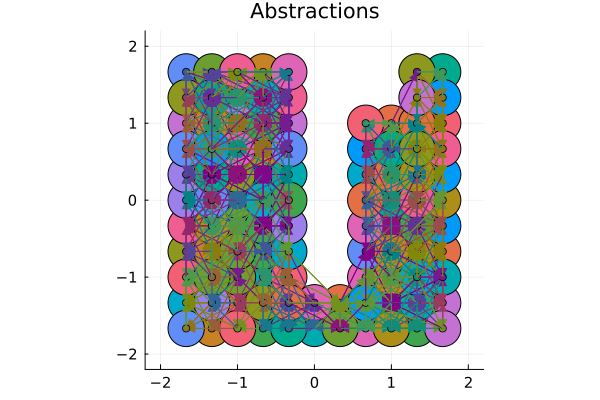

In [12]:
fig = plot(;
    aspect_ratio = :equal,
    xtickfontsize = 10,
    ytickfontsize = 10,
    guidefontsize = 16,
    titlefontsize = 14,
);
xlims!(rectX.A.lb[1] - 0.2, rectX.A.ub[1] + 0.2);
ylims!(rectX.A.lb[2] - 0.2, rectX.A.ub[2] + 0.2);
title!("Abstractions");
plot!(abstract_system; arrowsB = true, efficient = false, cost = false)

## Display the Lyapunov function and the trajectory

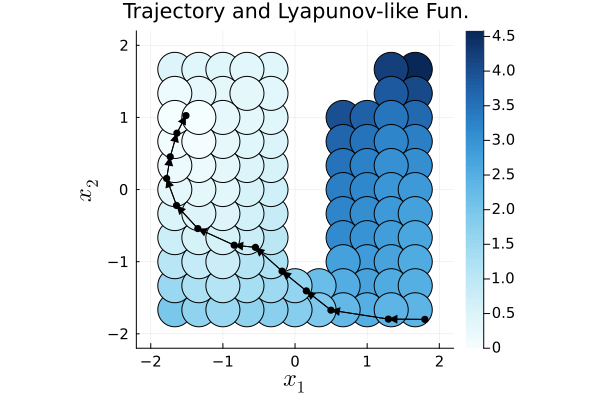

In [13]:
fig = plot(;
    aspect_ratio = :equal,
    xtickfontsize = 10,
    ytickfontsize = 10,
    guidefontsize = 16,
    titlefontsize = 14,
);
xlims!(rectX.A.lb[1] - 0.2, rectX.A.ub[1] + 0.2);
ylims!(rectX.A.lb[2] - 0.2, rectX.A.ub[2] + 0.2);
xlabel!("\$x_1\$");
ylabel!("\$x_2\$");
title!("Trajectory and Lyapunov-like Fun.");
plot!(abstract_system; arrowsB = false, value_function = optimizer.abstract_lyap_fun);
plot!(cost_control_trajectory; color = :black)

## References

1. L. N. Egidio, T. Alves Lima, R. M. Jungers, "State-feedback Abstractions for Optimal Control of Piecewise-affine Systems", IEEE 61st Conference on Decision and Control (CDC), 2022, accepted.
1. D. Bertsekas, "Dynamic programming and optimal control". Volume I, Athena scientific, 2012.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*